# **Lab 4 - Metodi iterativi**

Consideriamo un sistema lineare nella forma

$$\mathbf{A}\mathbf{x}=\mathbf{b},$$

dove $\mathbf{A}\in\mathbb{R}^{n\times n}$ e $\mathbf{b}\in\mathbb{R}^{n}$ sono noti, mentre $\mathbf{x}\in\mathbb{R}^{n}$ è il vettore incognito.

I metodi iterativi si basano sulla seguente idea: se $\mathbf{A}=\mathbf{M}-\mathbf{N}$, con $\mathbf{M}$ invertibile, allora la soluzione del sistema soddisfa

$$\mathbf{x}=\mathbf{M}^{-1}\left(\mathbf{N}\mathbf{x}+\mathbf{b}\right).$$

Visto che quest'ultima è un'equazione di punto fisso, la soluzione si può approssimare con lo schema iterativo

$$\mathbf{x}^{(k+1)}=\mathbf{M}^{-1}\left(\mathbf{N}\mathbf{x}^{(k)}+\mathbf{b}\right).$$

La matrice $\mathbf{B}:=\mathbf{M}^{-1}\mathbf{N}$ è detta *matrice di iterazione*. Se chiamiamo $\mathbf{c}:=\mathbf{M}^{-1}\mathbf{b}$, abbiamo la scrittura equivalente

$$\mathbf{x}^{(k+1)}=\mathbf{B}\mathbf{x}^{(k)}+\mathbf{c}.$$

I metodi di Jacobi e di Gauss-Seidel, costruiscono le matrici $\mathbf{M}$ ed $\mathbf{N}$ a partire da una decomposizione in matrici diagonali e tridiagonali. In particolare, se
$$\mathbf{A}=\mathbf{D}-\mathbf{E}-\mathbf{F},$$
con $\mathbf{D}$ diagonale, $\mathbf{E}$ e $\mathbf{F}$ tridiagonali (inferiore e superiore, rispettivamente), allora abbiamo
</br></br>
**Metodo di Jacobi** $\;\mapsto\;$ $\mathbf{M}=\mathbf{D},\;\;\mathbf{N}=\mathbf{E}+\mathbf{F}$</br></br>
**Metodo di Gauss-Seidel** $\;\mapsto\;$ $\mathbf{M}=\mathbf{D}-\mathbf{E},\;\;\mathbf{N}=\mathbf{F}$</br></br>

## Parte 1 - Implementazione

<mark>**Esercizio 1**</mark></br>
Scrivete una function, chiamata *DEFsplit* che, data $\mathbf{A}$, restituisce le corrispondenti matrici $\mathbf{D},\mathbf{E},\mathbf{F}$.

Hint: sfruttate le funzioni *diag*, *tril* e *triu* di numpy (o, equivalentemente, di scipy.linalg)!

In [ ]:
import numpy as np

def DEFsplit(A):
  D = np.diag(np.diag(A))
  E = -np.tril(A, k = -1)
  F = -np.triu(A, k = 1)
  return D, E, F

In [ ]:
## Per verificarne il funzionamento...

A = np.array([[6,1,5,8],
              [2,9,1,1],
              [3,7,2,4],
              [7,1,3,5]])

D, E, F = DEFsplit(A)

<mark>**Esercizio 2**</mark></br>
Scrivete una function chiamata *Jacobi_Bc* che, dati $\mathbf{A}$ e $\mathbf{b}$, restituisce la matrice d'iterazione $\mathbf{B}$ ed il vettore di shifting $\mathbf{c}$ associati al metodo di Jacobi. Scrivete quindi una seconda funzione, *GS_Bc*, che faccia la stessa cosa ma per il metodo di Gauss-Seidel.

Hint: per Jacobi, $\mathbf{M}^{-1}$ è nota in forma chiusa. Per Gauss-Seidel, potete calcolare l'azione di $\mathbf{M}^{-1}$ su $\mathbf{N}$, piuttosto che $\mathbf{M}^{-1}$ (sfruttate la funzione *solve_triangular* del pacchetto *scipy.linalg*)!

In [ ]:
def Jacobi_Bc(A, b = None):

  D, E, F = DEFsplit(A)
  M = D
  N = E+F

  Minv = np.diag(1.0/np.diag(M))
  B = Minv @ N

  if(b is None):
    return B
  else:
    c = Minv @ b
    return B, c

In [ ]:
from scipy.linalg import solve_triangular

def GS_Bc(A, b = None):

  D, E, F = DEFsplit(A)
  M = D-E
  N = F

  B = solve_triangular(M, N, lower = True)

  if(b is None):
    return B
  else:
    c = solve_triangular(M, b, lower = True)
    return B, c

<mark>**Esercizio 3**</mark></br>
Scrivete una function chiamata *iterative_solve* che, dati

- $\mathbf{A}$ matrice del sistema
- $\mathbf{b}$ termine noto
- $\mathbf{x}_{0}$ guess iniziale
- il nome del metodo ("Jacobi" o "GS")

approssimi la soluzione $\mathbf{x}$ con il metodo iterativo corrispondente. La function dovrà accettare anche altri due parametri: **nmax**, cioè il numero massimo di iterazioni, **rtoll**, la tolleranza relativa richiesta. Il particolare, il metodo iterativo va arrestato se

$$\frac{\|\mathbf{r}^{(k)}\|}{\|\mathbf{b}\|}<\textbf{rtoll},$$

dove $\mathbf{r}^{(k)}:=\mathbf{A}\mathbf{x}^{(k)}-\mathbf{b}$ è il residuo alla *k*-esima iterazione.

*Nota*: costruite la function di modo che, in output, essa restituisca la lista delle iterate $[\mathbf{x}_{1},\dots,\mathbf{x}_{N}]$.

In [ ]:
def iterative_solve(A, b, x0, method, nmax, rtoll):

  r = A @ x0 - b
  bnorm = np.linalg.norm(b)

  if(method == 'Jacobi'):
    B, c = Jacobi_Bc(A, b)
  elif(method == 'GS'):
    B, c = GS_Bc(A, b)
  else:
    raise RuntimeError("Metodo sconosciuto.")

  k = 0
  xiter = [x0]

  while( (np.linalg.norm(r)/bnorm) > rtoll  and k < nmax):
    xold = xiter[-1]
    xnew = B @ xold + c
    xiter.append(xnew)
    r = A @ xnew - b
    k = k+1

  return xiter

## Parte 2 - Sperimentazione

<mark>**Esercizio 4**</mark></br>
Si consideri la seguente matrice quadrata


$$\mathbf{A}=\left[\begin{array}{cccccc}
1 & 1 & 1 & 1 & \dots & 1\\
R_{1} & - R_{2} & 0 & 0 & \dots & 0\\
0 & R_{1} & - R_{2} & 0 &  \dots & 0\\
\dots & 0 & \ddots & \ddots &   & \dots\\
\dots & \dots &  & \ddots &  \ddots & \dots\\
0 & 0 & 0 & \dots & R_{1} & - R_{2} \\
\end{array}\right]$$


di dimensione $n=100$, avendo posto $R_{1}=1$ ed $R_{2}=2$.
</br></br>
a) Assemblare le matrici di iterazione $B_{\text{J}}$ e $B_{\text{GS}}$ dei metodi di Jacobi e Gauss-Seidel, quindi calcolarne i rispettivi raggi spettrali. La condizione
necessaria e sufficiente per la convergenza del metodo iterativo è soddisfatta in entrambi i casi?

*Hint: usate la function $\texttt{eigvals}$ di $\texttt{scipy.linalg}$.*
</br></br>
b) Sia $\mathbf{b}=[2,1,1,\dots,1]^{\top}\in\mathbb{R}^{n}$. Approssimare la soluzione del sistema lineare $\mathbf{A}\mathbf{x}=\mathbf{b}$ con il metodo di Jacobi. Si pongano $$\mathbf{x}_{0}=[0,\dots,0]^{\top},\quad\texttt{rtoll}=10^{-6},\quad\texttt{nmax}=1000.$$ Il metodo converge? Se sì, in quante iterazioni?

In [ ]:
# Costruzione della matrice A
n = 100
R1, R2 = 1, 2

A = -R2*np.diag(np.ones(n))
A[0,:] = 1
A = A + R1*np.diag(np.ones(n-1), -1)

In [ ]:
# a) Raggi spettrali

from scipy.linalg import eigvals

Bj = Jacobi_Bc(A)
BGS = GS_Bc(A)

rhoj = np.max(np.abs(eigvals(Bj)))
rhoGS = np.max(np.abs(eigvals(BGS)))

In [ ]:
print("Raggio spettrale Jacobi: %.4f" % rhoj)
print("Raggio spettrale Gauss-Seidel: %.4f" % rhoGS)

Raggio spettrale Jacobi: 0.7071
Raggio spettrale Gauss-Seidel: 1.0000


In [ ]:
# b) Applicazione di Jacobi

b = np.ones(n)
b[0] = 2

x0 = np.zeros(n)

xiter = iterative_solve(A, b, x0, method = 'Jacobi', nmax = 1000, rtoll = 1e-6)

In [ ]:
print("Numero iterazioni: %d.\n" % len(xiter))
print("Soluzione approssimata:")
xiter[-1]

Numero iterazioni: 48.

Soluzione approssimata:


array([49.99999456, 24.5000007 , 11.75000307,  5.37500118,  2.18749906,
        0.59374894, -0.20312506, -0.601562  , -0.80078097, -0.90039074,
       -0.95019551, -0.9750977 , -0.98754875, -0.99377435, -0.99688722,
       -0.99844364, -0.99922181, -0.99961089, -0.99980544, -0.99990272,
       -0.99995137, -0.99997568, -0.99998784, -0.99999392, -0.99999696,
       -0.99999848, -0.99999924, -0.99999962, -0.99999981, -0.9999999 ,
       -0.99999995, -0.99999998, -0.99999999, -0.99999999, -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

<mark>**Esercizio 5**</mark></br>
Si considerino la matrice ed il termine noto


$$\mathbf{A}=\left[\begin{array}{rrrrrrr}
9 & -3 & 1 &  &  & & \\
-3 & 9 & -3 & 1 &  & & \\
1 & -3 & 9 & -3 & 1 & & \\
& 1 & -3 & 9 & -3 & 1 &\\
& & 1 & -3 & 9 & -3 & 1 \\
& & & 1 & -3 & 9 & -3  \\
& & & & 1 & -3 & 9  \\
\end{array}\right],\quad\quad \mathbf{b}=\left[\begin{array}{c}7\\4\\5\\5\\5\\4\\7\end{array}\right].$$
</br>
a) Discutere le proprietà della matrice $\mathbf{A}$ (è simmetrica? è definita positiva$^*$? è a dominanza diagonale per righe?)
</br></br>
b) Approssimare la soluzione del sistema lineare $\mathbf{A}\mathbf{x}=\mathbf{b}$ con i metodi di Jacobi e di Gauss-Seidel, utilizzando il vettore nullo come guess iniziale. Si ponga $\texttt{rtoll}=10^{-6}$ e $\texttt{nmax}=1000$. Confrontare il numero
di iterazioni necessarie per arrivare a convergenza per i due metodi e commentare i risultati
ottenuti.
</br>
</br>
$^*$*Hint: sfruttate la function $\texttt{eigvalsh}$ del pacchetto $\texttt{scipy.linalg} $ (perché??)*


In [ ]:
# a) Assemblaggio di A e check delle proprietà

n = 7
A = - 3*np.diag(np.ones(n-1), 1) + np.diag(np.ones(n-2), 2)
A = 9*np.diag(np.ones(n)) + A + A.T

# Simmetrica: sì, si vede ad occhio! (oppure, vedasi Es. 7 per un check "al calcolatore")
# Dominanza diagonale per righe: sì, si vede ad occhio! (oppure, vedasi Es. 7 per un check "al calcolatore")

# Definita positiva? Guardiamo il più piccolo degli autovalori

from scipy.linalg import eigvalsh

np.min(eigvalsh(A))

4.904226454981309

In [ ]:
# b) Applicazione dei metodi e confronto
b = np.array([7, 4, 5, 5, 5, 4, 7])

x0 = np.zeros(n)

xj = iterative_solve(A, b, x0, method = 'Jacobi', rtoll = 1e-6, nmax = 1000)
xgs = iterative_solve(A, b, x0, method = 'GS', rtoll = 1e-6, nmax = 1000)

In [ ]:
print("\t\t\tJacobi\tGauss-Seidel\n" + "-"*44)
print("Convergenza:\t\t%s\t%s" % (len(xj)<1000, len(xgs)<1000))
print("Numero di iterazioni:\t%d\t%d" % (len(xj), len(xgs)))

			Jacobi	Gauss-Seidel
--------------------------------------------
Convergenza:		True	True
Numero di iterazioni:	50	13


## Parte 3 - Metodi pre-implementati: gradiente coniugato

<mark>**Esercizio 6**</mark></br>
La function $\texttt{cg}$ del pacchetto $\texttt{scipy.sparse.linalg}$ implementa il metodo del gradiente coniugato. Viceversa, la function $\texttt{gdescent}$, disponibile nello script $\texttt{utils.py}$, implementa il metodo del gradiente.

Una volta appurato che entrambi i metodi sono applicabile al problema dell'esercizio 5,
</br></br>
a) Approssimare la soluzione del sistema con i metodi del gradiente e del gradiente coniugato. Si utilizzino gli stessi iperparametri usati all'es. 5 (guess iniziale, tolleranza relativa, numero massimo di iterazioni). I metodi convergono? Che soluzione si ottiene?
</br></br>
b) Nei due casi, quante iterazioni ci sono volute? *Hint: per $\texttt{cg}$, sfruttate l'input opzionale $\texttt{callback}$*!

In [ ]:
from scipy.sparse.linalg import cg

x, info = cg(A, b, x0, tol = 1e-6, maxiter = 1000, callback = lambda xk: print("step!"))

print("\nSoluzione approssimata (CG):")
print(x)

step!
step!
step!
step!

Soluzione approssimata (CG):
[1. 1. 1. 1. 1. 1. 1.]


In [ ]:
from utils import gdescent
xg = gdescent(A, b, x0, nmax = 10000, rtoll = 1e-5)

print("Soluzione approssimata (Gradient descent):")
print(xg[-1])

Soluzione approssimata (Gradient descent):
[0.99999958 0.99999228 0.99999331 0.99998581 0.99999331 0.99999228
 0.99999958]


In [ ]:
len(xg) # numero iterazioni metodo del gradiente

18

## Esercizi per casa

<mark>**Esercizio 7**</mark></br>
Scrivete le seguenti function a valori booleani (vero o falso):

- **sym** che, data $\mathbf{A}$, restituisce $\texttt{True}$ se e solo se $\mathbf{A}$ è simmetrica;

- **sdp** che, data $\mathbf{A}$, restituisce $\texttt{True}$ se e solo se $\mathbf{A}$ è simmetrica definita positiva;

- **rowdom** che, data $\mathbf{A}$, restituisce $\texttt{True}$ se e solo se $\mathbf{A}$ è a dominanza diagonale per righe.

In [ ]:
def sym(A):
  return np.min(np.abs(A-A.T))<1e-15

def sdp(A):
  if(sym(A)):
    return np.min(eigvalsh(A))>0
  else:
    return False

def rowdom(A):
  d = np.diag(A)
  Aoff = A-np.diag(d)
  off_sums = np.sum(np.abs(Aoff), axis = 1)

  return np.all(np.abs(d) >= off_sums)

<mark>**Esercizio 8**</mark></br>
Si considerino la matrice pentadiagonale ed il termine noto


$$\mathbf{A}=\left[\begin{array}{rrrrrrr}
5 & -1 & -1 &  &  & & \\
-1 & 5 & -1 & -1 &  & & \\
-1 & -1 & 5 & -1 & -1 & & \\
& \ddots  & \ddots & \ddots & \ddots & \ddots  &\\
& & -1 & -1 & 5 & -1 & -1 \\
& & &  -1 & -1 & 5 & -1 \\
& & & & -1 & -1 & 5 \\
\end{array}\right],\quad\quad \mathbf{b}=\left[\begin{array}{c}0.2\\0.2\\0.2\\\vdots\\0.2\\0.2\\0.2\end{array}\right].$$
</br>
a) La matrice $\mathbf{A}$ è simmetrica definitiva positiva?
</br></br>
b) Approssimare la soluzione del sistema lineare con i metodi di Jacobi, Gauss-Seidel, Gradiente e Gradiente Coniugato (si utilizzi il vettore nullo come guess iniziale, $10^{-5}$ come tolleranza relativa, $10000$ come numero massimo di iterazioni).
</br></br>
c) Plottare l'andamento del residuo relativo $\|\mathbf{r}^{(k)}\|/\|\mathbf{b}\|$ in funzione delle iterate $k$, mettendo così a paragone i quattro metodi.


In [ ]:
# a) Assemblaggio matrice e check proprietà
n = 50
A = -np.diag(np.ones(n-1), 1)-np.diag(np.ones(n-2), 2)
A = 5*np.diag(np.ones(n)) + A + A.T

sdp(A)

True

In [ ]:
# b) Applicazione dei metodi iterativi

b = 0.2*np.ones(n)
x0 = np.zeros(n)

# Gradiente
xgd = gdescent(A, b, x0 = x0, rtoll = 1e-5, nmax = 10000)

# Gradiente coniugato (sfruttiamo il callback per salvare le iterate: ci servirà dopo)
xcg = [x0]
cg(A, b, x0 = x0, tol = 1e-5, maxiter = 10000, callback = lambda xk: xcg.append(xk+0.0))

# Jacobi
xj = iterative_solve(A, b, x0, method = 'Jacobi', rtoll = 1e-5, nmax = 10000)

# Gauss-Seidel
xgs = iterative_solve(A, b, x0, method = 'GS', rtoll = 1e-5, nmax = 10000)

In [ ]:
# c) Calcolo dei residui e plot
bnorm = np.linalg.norm(b)

rj = [np.linalg.norm(A@xk-b)/bnorm for xk in xj]
rgs = [np.linalg.norm(A@xk-b)/bnorm for xk in xgs]
rgd = [np.linalg.norm(A@xk-b)/bnorm for xk in xgd]
rcg = [np.linalg.norm(A@xk-b)/bnorm for xk in xcg]

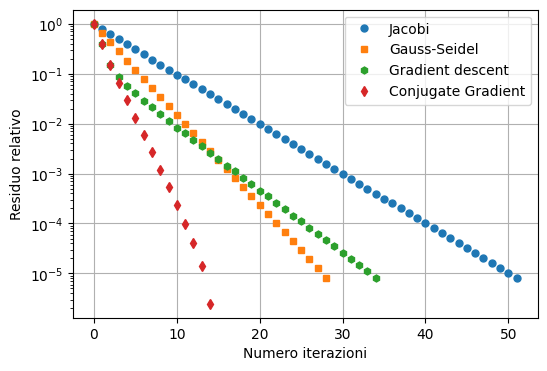

In [ ]:
import matplotlib.pyplot as plt

# Plot in scala logaritmica sulle y

plt.figure(figsize = (6, 4))
plt.semilogy(rj, 'o', label = 'Jacobi', markersize = 5)
plt.semilogy(rgs, 's', label = 'Gauss-Seidel', markersize = 5)
plt.semilogy(rgd, 'h', label = 'Gradient descent', markersize = 5)
plt.semilogy(rcg, 'd', label = 'Conjugate Gradient', markersize = 5)
plt.grid()
plt.legend()
plt.xlabel("Numero iterazioni")
plt.ylabel("Residuo relativo")
plt.show()